In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

from matplotlib.lines import Line2D

def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels

    return df


def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

In [3]:
classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors=11),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

In [4]:
df = load_data_to_df()
data = df.drop("Label", axis=1)
labels = df["Label"]

In [5]:
conf_matrices = {name: [] for name in classifiers.keys()}
results = {name: [] for name in classifiers.keys()}

for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train.values, X_test.values)
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.values.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results.keys():
            results[name] = []
        results[name].append(accuracy)
        conf_matrices[name].append(confusion_matrix(y_test, y_pred))

clf_acc_df = pd.DataFrame(results.items(), columns=["Classifier", "Accuracy"])

# Average the confusion matrices
for name in classifiers.keys():
    conf_matrices[name] = np.mean(conf_matrices[name], axis=0)

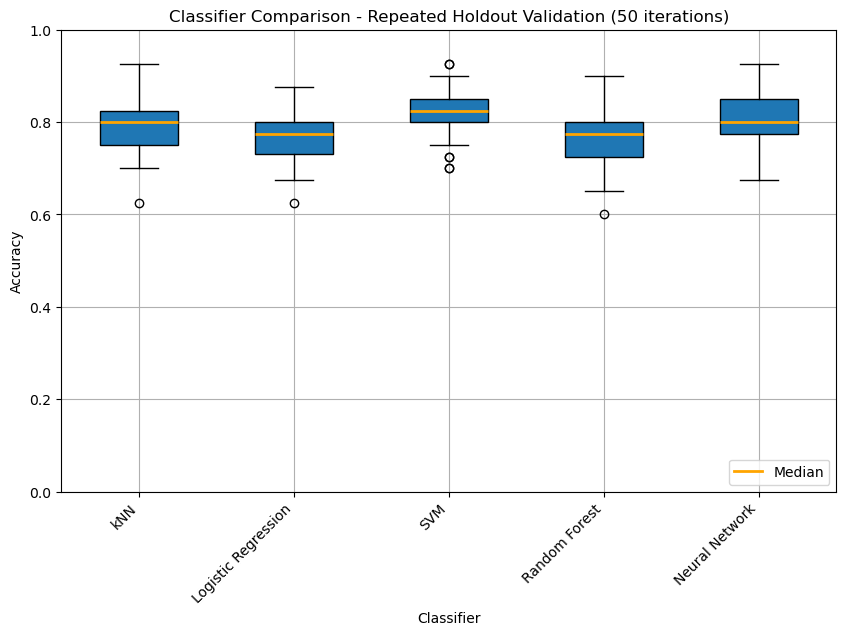

In [6]:
plt.figure(figsize=(10, 6))

bp = plt.boxplot(
    clf_acc_df["Accuracy"].tolist(),
    patch_artist=True,
    medianprops=dict(color="orange", linewidth=2),
)

plt.xticks(
    [i + 1 for i in range(len(clf_acc_df))],
    clf_acc_df["Classifier"],
    rotation=45,
    ha="right",
)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Classifier Comparison - Repeated Holdout Validation (50 iterations)")
plt.ylim(0.0, 1.0)
plt.grid(True)

custom_lines = [Line2D([0], [0], color="orange", lw=2)]
plt.legend(custom_lines, ["Median"], loc="lower right")  # Change the legend position to lower right

plt.show()

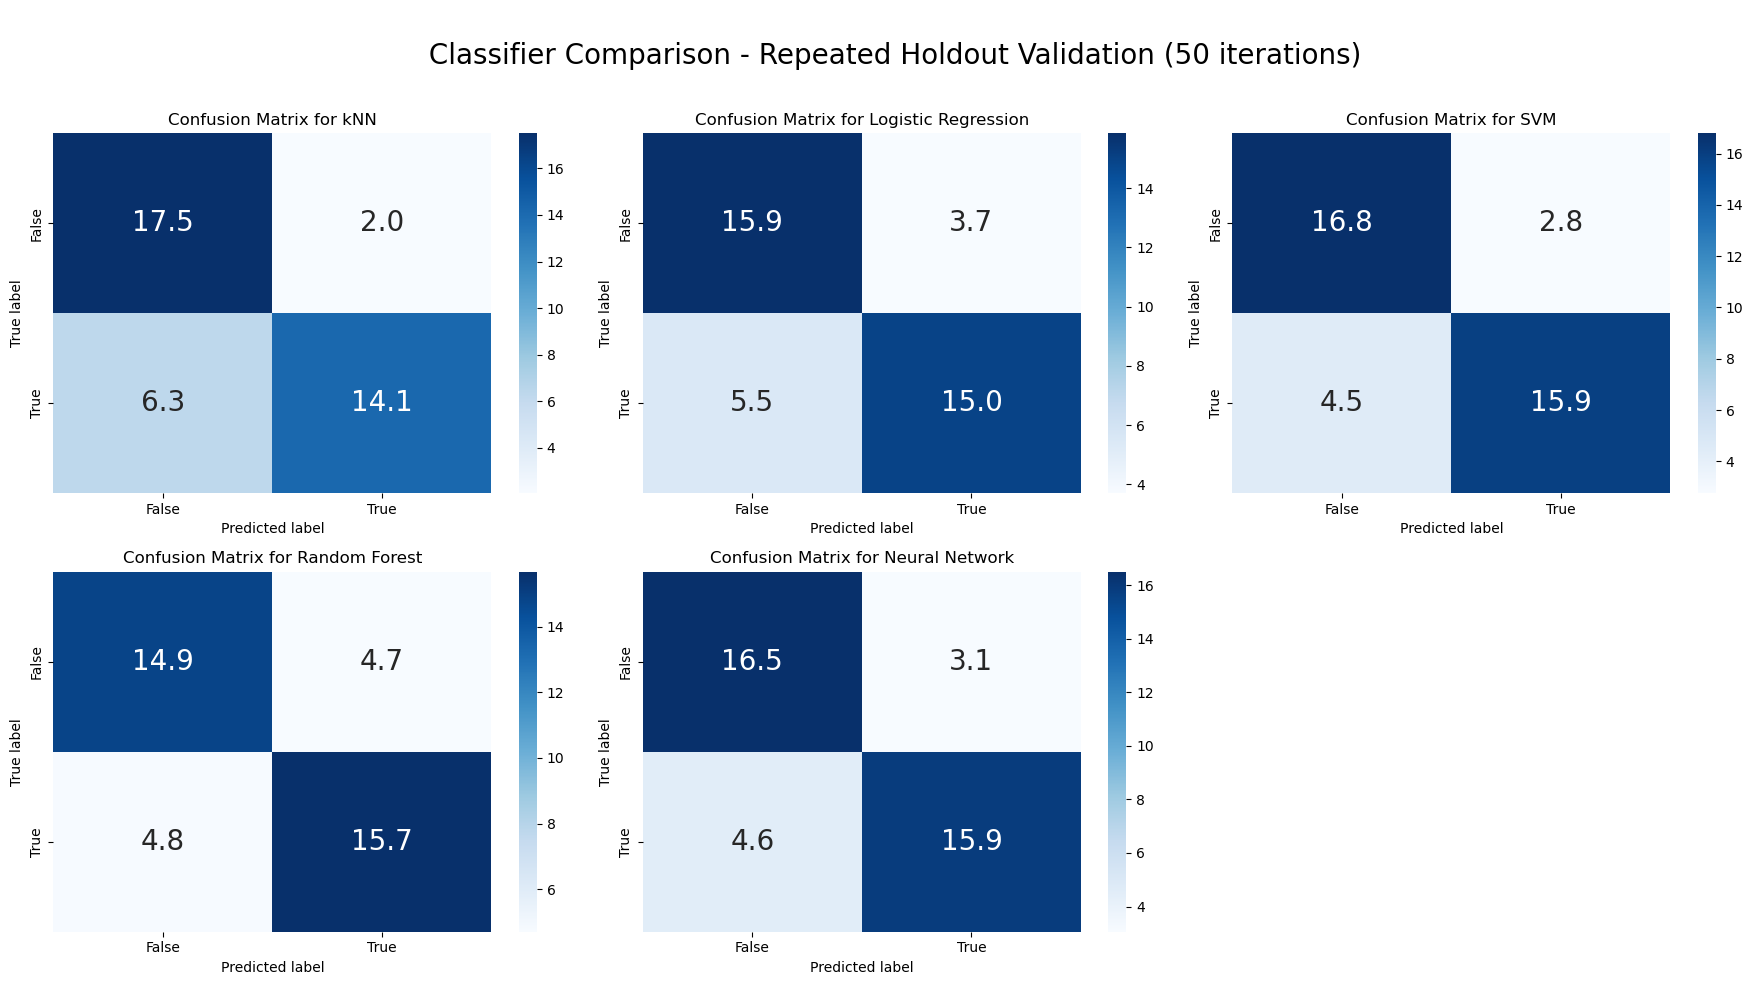

In [20]:
plt.figure(figsize=(18, 10))

for idx, (name, matrix) in enumerate(conf_matrices.items(), 1):
    plt.subplot(2, 3, idx)
    # Create a heatmap with custom x and y labels
    sns.heatmap(
        matrix,
        annot=True,  # Ensure annotations are enabled
        fmt=".1f",  # Adjust formatting to show one decimal place
        cmap="Blues",
        xticklabels=["False", "True"],
        yticklabels=["False", "True"],
        annot_kws={
            "size": 20,
        },  # Increase font size and specify color
    )
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plt.suptitle(
    "\n Classifier Comparison - Repeated Holdout Validation (50 iterations) \n",
    fontsize=20,
)
plt.tight_layout()
plt.show()

In [9]:
mislabeled = {name: [] for name in classifiers.keys()}
misclassification_counts = {name: {0: 0, 1: 0} for name in classifiers.keys()}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    y_pred_cv = cross_val_predict(clf, data, labels.values.ravel(), cv=kf)
    mislabeled_indices = np.where(labels.values.ravel() != y_pred_cv)[0]
    mislabeled[name].extend(mislabeled_indices)
    for idx in mislabeled_indices:
        true_label = labels.values.ravel()[idx]
        misclassification_counts[name][true_label] += 1

In [10]:
for name in classifiers.keys():
    print(f"Classifier: {name}")
    print(f"Misclassified cats (label 0): {misclassification_counts[name][0]}")
    print(f"Misclassified dogs (label 1): {misclassification_counts[name][1]}")
    print()

Classifier: kNN
Misclassified cats (label 0): 10
Misclassified dogs (label 1): 27

Classifier: Logistic Regression
Misclassified cats (label 0): 23
Misclassified dogs (label 1): 25

Classifier: SVM
Misclassified cats (label 0): 13
Misclassified dogs (label 1): 21

Classifier: Random Forest
Misclassified cats (label 0): 24
Misclassified dogs (label 1): 22

Classifier: Neural Network
Misclassified cats (label 0): 23
Misclassified dogs (label 1): 35



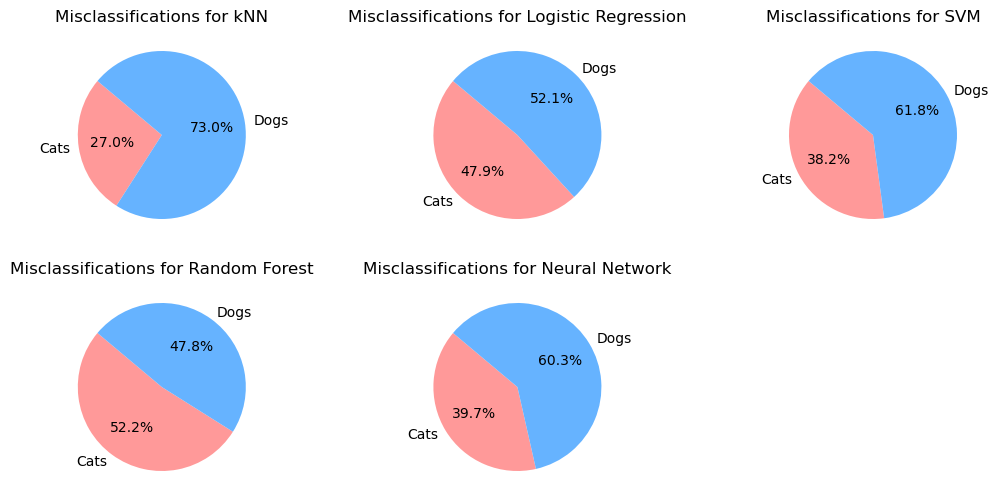

In [11]:
# Plot a circle graph for misclassified cats and dogs
plt.figure(figsize=(13, 6))
for idx, (name, counts) in enumerate(misclassification_counts.items(), 1):
    plt.subplot(2, 3, idx)
    plt.pie(
        counts.values(),
        labels=["Cats", "Dogs"],
        autopct="%1.1f%%",
        startangle=140,
        colors=["#ff9999", "#66b3ff"],
    )
    plt.title(f"Misclassifications for {name}")

In [12]:
all_mislabeled = np.concatenate(list(mislabeled.values()))
unique_indices, counts = np.unique(all_mislabeled, return_counts=True)
consistently_mislabeled = list(zip(unique_indices, counts))

consistently_mislabeled = [t for t in consistently_mislabeled if t[1] > 1]

consistently_mislabeled = sorted(
    consistently_mislabeled, key=lambda x: x[1], reverse=True
)

In [13]:
mislabeled_by_all_clfs = [
    t for t in consistently_mislabeled if t[1] == 5
] 

In [21]:
print(f"Number of images misclassified by all classifiers: {len(mislabeled_by_all_clfs)}")

Number of images misclassified by all classifiers: 13


In [24]:
# Remove the last element from the list
mislabeled_by_all_clfs = mislabeled_by_all_clfs[:-1]

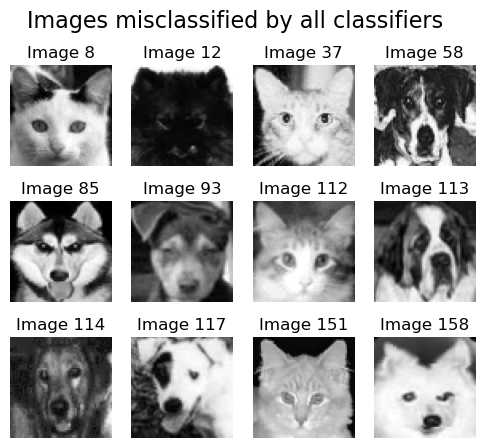

In [41]:
# Plot the iamges that is mislabeled by all classifiers
plt.figure(figsize=(6, 5))
for idx, (im_idx, _) in enumerate(mislabeled_by_all_clfs, 1):
    plt.subplot(3, 4, idx)
    plt.imshow(data.iloc[im_idx].values.reshape(64, 64), cmap="gray")
    plt.title(f"Image {im_idx}")
    plt.axis("off")

plt.suptitle("Images misclassified by all classifiers\n", fontsize=16)
plt.show()

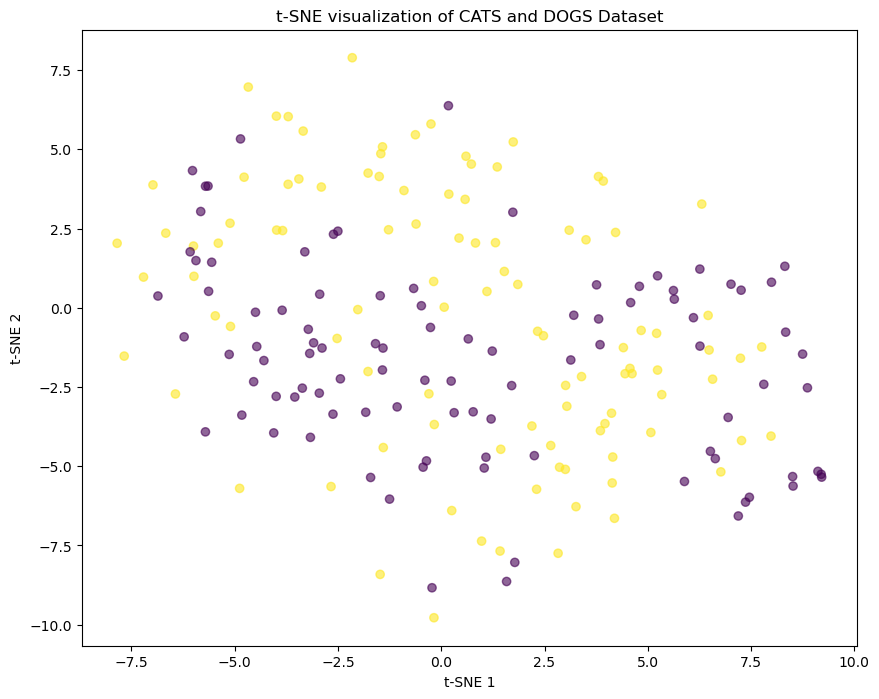

In [ ]:
# Optional: Scale the data to normalize feature variance
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:, :-1])

# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42) 
data_tsne = tsne.fit_transform(data_scaled)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    data_tsne[:, 0],
    data_tsne[:, 1],
    c=df["Label"],
    cmap="viridis",
    alpha=0.6,
)
plt.title("t-SNE visualization of CATS and DOGS Dataset")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(False)
plt.show()